# Updating Parquet Files Using Dask

In [2]:
import sys
import math
import copy

import boto3
import toolz
import snappy
import fastparquet
import numpy as np
import pandas as pd
from dask import delayed
import dask.dataframe as dd

import fastparquet

## Motivation
To build our "data lake", a couple of questions need to be answered (and accompanied by Python implementations/prototypes) related to the updating and appending to of Parquet files stored in S3. For an arbitrary dataset, there are four cases that need to be covered:

1. Updating an existing Parquet file when records are added
2. Updating an existing Parquet file when records are deleted
3. Updating an existing Parquet file when records are altered

In addition to meeting the conditions for performing the above operations, questions to considered include:

1. If we use combine_first to update rows (e.g. see [here](https://citybase.atlassian.net/browse/DS-79?focusedCommentId=53549&page=com.atlassian.jira.plugin.system.issuetabpanels:comment-tabpanel#comment-53549)) in an S3+Parquet-backed Dask DataFrame, will actual computations with the result require the entire dataset? More specifically, assuming a dataset is partitioned on disk using separate files, will combine_first only generate graphs that require the files corresponding to the affected partitions? Inspect the resulting graph within DataFrame.dask.  
2. Will an update to disk (i.e. writing back to the S3 Parquet file using to_parquet) require the entire dataset?

Also, we will need to devise a means of applying [DMS-generated updates](https://docs.aws.amazon.com/dms/latest/userguide/CHAP_Target.S3.html).

First, we'll start with a toy dataset with some updates which we will create and upload to S3 as a Parquet file. To start, we will partition into 3 partitions.

In [3]:
toy_data = pd.DataFrame(data=[['Vidal', 1, 'large'],
                              ['Brandon', 2, 'medium'],
                              ['Alex', 3, 'large'],
                              ['Duffy', 4, 'large'],
                              ['Liz', 5, 'small'],
                              ['James', 6, 'large'],
                              ['Jack', 7, 'medium'],
                              ['Jill', 99, 'large'],
                              ['Donna', 9, 'large'],
                              ['Mikey', 10, 'small']], 
                        columns=['name', 'num', 'shirt_size'], index=range(1,11))

# Create Dask DataFrames for above toy data
toy_data_dd = dd.from_pandas(toy_data, 
                             npartitions = 3)
                                
toy_data_dd.to_parquet('s3://cb-pdj-test/toy_data_dd.parq', compression='snappy')

### Case 1: Updating Existing File With New Records

When updating data to reflect addition of new records, there are two potential scenarios we might encounter.

**1.** When identifying new rows of data to append to our data in S3, one approach for identifying the new rows can involve the use of a timestamp or other indicator that the record is "new". There may also be instances where such timestamp or indicator does not exist, and identifying the new rows necessarily involves comparing the updated data to the older data. For example, if in my older dataset I have 100 records with indices 1-100, and my updated dataset has 105 records with new records having indicies 101-105, we can determine by comparison which records are new. We assume here that old records have not been updated. My hypothesis is that determining which records are new necessarily requires a reading in of the entire dataset and a re-writing of the entire dataset.

**2.** In the second scenario, our new data may come in the form of a "stream" or from a relational database that has a timestamp. Once those "new" records are identified, they can simply be appended to existing Parquet files as new partitions using `to_parquet` argument `append=True`.

#### Scenario 1: Using Combine First to Update 

We start by setting up our "new" dataset, which has two new records with indicies 11 and 12.

In [4]:
toy_data_new = pd.DataFrame(data=[['Vidal', 1, 'large'],       # Old Records
                                 ['Brandon', 2, 'medium'],    # ...
                                 ['Alex', 3, 'large'],        # ...
                                 ['Duffy', 4, 'large'],       # ...
                                 ['Liz', 5, 'small'],         # ...
                                 ['James', 6, 'large'],       # ...
                                 ['Jack', 7, 'medium'],       # ...
                                 ['Jill', 99, 'large'],       # ...
                                 ['Donna', 9, 'large'],       # ...
                                 ['Mikey', 10, 'small'],      # ...
                                 ['Max', 1, 'small'],         # New Record
                                 ['Madison', 6, 'small']],    # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = range(1,13))
toy_data_new_dd = dd.from_pandas(toy_data_new, chunksize=3)

Next, we read in the Parquet file ("old" dataset) and use combine first to combine with the new data. We see in the graph below that all three partitions of `toy_data_dd.parq` are read and merged with the new data. In answer to question number one above, we find that, though there are only updates in this dataset to the last partition, all partitions are read when using `combine_first`.

DIVISIONS OF OLD DATA: (1, 5, 9, 10)
DIVISIONS OF NEW DATA: (1, 4, 7, 10, 12)
DIVISIONS OF UPDATED : (1, 4, 5, 7, 9, 10, 12)


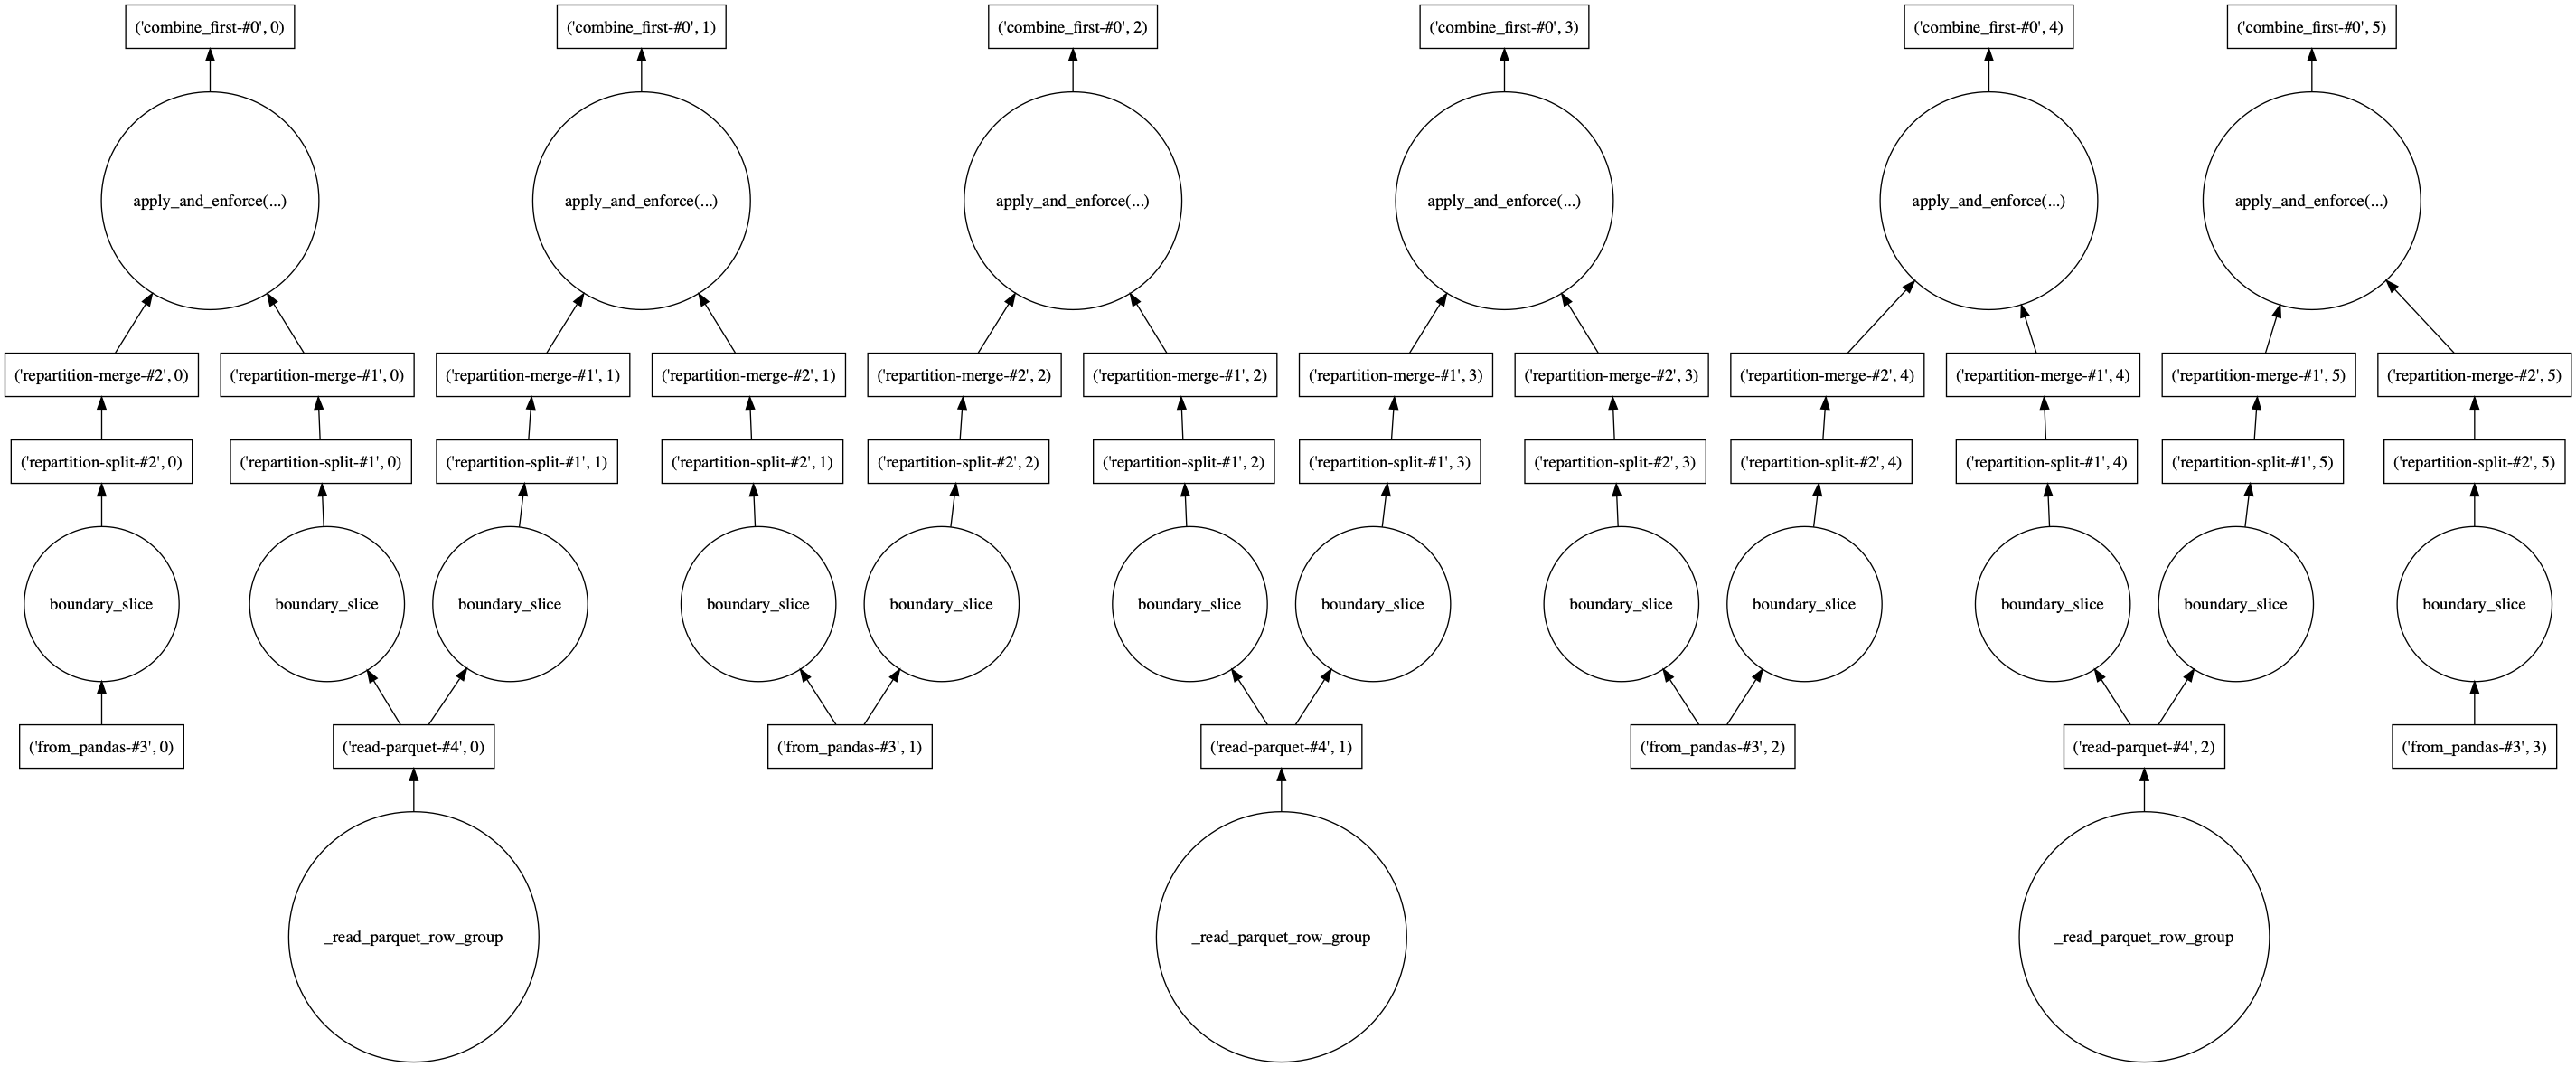

In [5]:
# Read in Parquet file from S3
toy_data_rd = dd.read_parquet('s3://cb-pdj-test/toy_data_dd.parq')
print('DIVISIONS OF OLD DATA:', toy_data_dd.divisions)
print('DIVISIONS OF NEW DATA:', toy_data_new_dd.divisions)

# Combine the old data and the new data using combine_first
updated = toy_data_new_dd.combine_first(toy_data_rd)

print('DIVISIONS OF UPDATED :', updated.divisions)
updated.visualize()

In [6]:
updated.compute()

,name,num,shirt_size
1,Vidal,1,large
2,Brandon,2,medium
3,Alex,3,large
4,Duffy,4,large
5,Liz,5,small
6,James,6,large
7,Jack,7,medium
8,Jill,99,large
9,Donna,9,large
10,Mikey,10,small


#### Scenario 2: Appending New Data
In this scenario, I provide an example of appending rows to a dataset. Below we add two records to the Parquet file `toy_data_dd.parq`. Note that the two new records have two distinct indicies not present in the "old" dataset.

In [7]:
toy_data_append = pd.DataFrame(data=[['Max', 77, 'small'],        # New Record
                                     ['Madison', 56, 'small']],   # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = [11,12])
toy_data_append_dd = dd.from_pandas(toy_data_append, npartitions=1)

In [8]:
toy_data_append_dd.to_parquet('s3://cb-pdj-test/toy_data_dd.parq', compression='snappy', append=True, ignore_divisions = True)

In [9]:
dd.read_parquet('s3://cb-pdj-test/toy_data_dd.parq').compute()

,name,num,shirt_size
index,,,
1,Vidal,1,large
2,Brandon,2,medium
3,Alex,3,large
4,Duffy,4,large
5,Liz,5,small
6,James,6,large
7,Jack,7,medium
8,Jill,99,large
9,Donna,9,large


<br>
<br>
<br>
<br>
<br>

### Case 2: Updating Existing File with Deleted Records

For this case, we use a similar approach to that used in **Case 1, Scenario 1**. To illustrate how dropped records can be retained despite having been deleted in a newer dataset, we use `combine_first` again to get the union of two datasets. In addition to dropping two records, we also add records with indicies 11 and 12.

In [10]:
toy_data_drop = pd.DataFrame(data=[['Vidal', 1, 'large'],       # Old Records
                                 ['Brandon', 2, 'medium'],    # ...
                                 ['Alex', 3, 'large'],        # ...
                                 ['Duffy', 4, 'large'],       # ...
                              #  ['Liz', 5, 'small'],         # DROP
                                 ['James', 6, 'large'],       # ...
                                 ['Jack', 7, 'medium'],       # ...
                                 ['Jill', 99, 'large'],       # ...
                               # ['Donna', 9, 'large'],       # DROP
                                 ['Mikey', 10, 'small'],      # ...
                                 ['Max', 1, 'small'],         # New Record
                                 ['Madison', 6, 'small']],   # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = [1,2,3,4,6,7,8,10,11,12])
toy_data_new_dd = dd.from_pandas(toy_data_drop, chunksize=3)

**NOTE:** As noted in previous work, the result of `combine_first` in this case returns the `num` column as `float` instead of as `int`. The following cell contains code taken from Brandon's `data-frame-updates` APC workaround.

In [11]:
# Taken from https://github.com/CityBaseInc/data-science-dags/blob/data-frame-updates/citybase_etl/operators/apc.py#L20
update_dtypes = {k: getattr(toy_data_new_dd[k].dtype, 'name', v)
                     for k, v in toy_data_new_dd.dtypes.items()}
toy_data_new_dd = toy_data_new_dd.astype(update_dtypes)

In [12]:
toy_data_new_dd.compute()

,name,num,shirt_size
1,Vidal,1,large
2,Brandon,2,medium
3,Alex,3,large
4,Duffy,4,large
6,James,6,large
7,Jack,7,medium
8,Jill,99,large
10,Mikey,10,small
11,Max,1,small
12,Madison,6,small


## Digression: Writing Only to Editied Parquet Partitions

As noted in [Case 1](#Case 1: Updating Existing File With New Records), as the `to_parquet` method currently functions, there isn't a way of updating only the specific partitions that contain new or editied data. For example, if I were to append data to an existing dataset with existing indicies, an error is returned. Here is the existing dataframe.

In [13]:
toy_data_dd.to_parquet('./toy_data_dd.parq', compression='snappy')
tdr = dd.read_parquet('./toy_data_dd.parq')
tdr.compute()

,name,num,shirt_size
index,,,
1,Vidal,1,large
2,Brandon,2,medium
3,Alex,3,large
4,Duffy,4,large
5,Liz,5,small
6,James,6,large
7,Jack,7,medium
8,Jill,99,large
9,Donna,9,large


We will now attempt to add two new/updated records having the same indicies as two records that already exist in the dataset, at indicies 5 and 7. Note, we use `append=True`. We get an error as a result.

In [14]:
toy_data_add = pd.DataFrame(data=[['Jim', 1, 'small'],       # New Record
                                  ['Madeline', 6, 'small']], # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = [5,7])

# Create Dask DataFrame from toy_data_add
tda = dd.from_pandas(toy_data_add, npartitions=1)

# Append without setting ignore_divisions to False
tda.to_parquet('./test.parq', compression='snappy', append=True)

KeyError: 'index'

Repeating the above step, this time adding the argument `ignore_divisions`, the code to append the data works, and results in a new partition being created.

In [15]:
print("PARTITIONS BEFORE:", dd.read_parquet('./test.parq').npartitions,
      "\nDIVISIONS:", dd.read_parquet('./test.parq').divisions)


PARTITIONS BEFORE: 4 
DIVISIONS: (None, None, None, None, None)


In [16]:
tda.to_parquet('./test.parq', compression='snappy', append=True, ignore_divisions=True)

In [17]:
print("PARTITIONS AFTER:", dd.read_parquet('./test.parq').npartitions,
      "\nDIVISIONS:", dd.read_parquet('./test.parq').divisions)


PARTITIONS AFTER: 5 
DIVISIONS: (None, None, None, None, None, None)


The issue with a new partition being created is that now we have a new partition that does not follow the ordered convention of the other partitions. Furthermore, we lose the divisions indicies in the metadata. Also, now there are two records with the index 5 and index 7. We could technically proceed as is and handle duplicates in the future upon reading in the data, but then we get run into the issue of re-reading and re-writing the entire dataset upon deletion and correction of the indicies all over again.

A desirable feature for updating Parquet files with Dask would be the ability for Dask to update records for indicies that already exist by:
1. Read the Parquet metadata to determine where those indicies are
2. Read in the data for only those partitions
3. Reconcile the changes in within the Pandas dataframe
4. Re-write the partition
5. Update the meta data



### Examining Dask and Fastparquet Source Code

Next, I'll examine the source code for both Dask and Fastparquet to determine where the necessary changes to either may need to be made. The following questions should be addressed:

1. When reading in a Parquet file, where does the meta data get read and how is that meta data represented and used?
2. When appends to Parquet files are made, where in the meta data are there updates and how are they handled?

#### Reading in Parquet Files and Examining Metadata

As can be seen in the [Dask source code](https://github.com/dask/dask/blob/5255092ecb98858451d35efaedb3ae03036870b1/dask/dataframe/io/parquet.py#L177), parquet files are read using the [`ParquetFile`](https://github.com/dask/fastparquet/blob/master/fastparquet/api.py#L25) class from the `fastparquet` package. 

In [100]:
f3 = fastparquet.api.ParquetFile('./toy_data_dd.parq')

The file structure for each `.parq` file is as follows:
- toy_data_dd.parq
    - _common_metadata
    - _metadata
    - **part.0.parquet** | type `fastparquet.parquet_trift.parquet.ttypes.RowGroup`
        - column1, 'index' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
          .  
          .  
        - column4, 'shirt_size' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
        <br>
    - **part.1.parquet** | type `fastparquet.parquet_trift.parquet.ttypes.RowGroup`  
        - column1, 'index' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
          .  
          . 
        - column4, 'shirt_size' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
        <br>
    - **part.2.parquet** | type `fastparquet.parquet_trift.parquet.ttypes.RowGroup`  
        - column1, 'index' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
          .  
          .  
        - column4, 'shirt_size' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  

In [101]:
part1 = f3.row_groups[0]

In [102]:
col1 = part1.columns[0]
col1

<class 'fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk'>
file_offset: 61
file_path: part.0.parquet
meta_data: <class 'fastparquet.parquet_thrift.parquet.ttypes.ColumnMetaData'>
  codec: 1
  data_page_offset: 4
  dictionary_page_offset: None
  encoding_stats: [<class 'fastparquet.parquet_thrift.parquet.ttypes.PageEncodingStats'>
count: 1
encoding: 0
page_type: 0
]
  encodings: [3, 4, 0]
  index_page_offset: None
  key_value_metadata: []
  num_values: 4
  path_in_schema: ['index']
  statistics: <class 'fastparquet.parquet_thrift.parquet.ttypes.Statistics'>
    distinct_count: None
    max: b'\x04\x00\x00\x00\x00\x00\x00\x00'
    max_value: None
    min: b'\x01\x00\x00\x00\x00\x00\x00\x00'
    min_value: None
    null_count: 0

  total_compressed_size: 57
  total_uncompressed_size: 63
  type: 2


### Finding: Partitions Overwritable Without Updating Metadata - Kinda
It's possible to write two distinct `.parq` files, swap out a `part.i.parquet` file from one `.parq` folder to another, and sucessfully read in the data with the changes reflected. However, it does have limitations. Anytime the type of a value is changed (ex. changing a string for an integer), it suddently fails to read because the file's data does not match the metadata, which remained unchanged when the file swap was made. Here is an example where we make a change in line 10:

In [103]:
swap = pd.DataFrame(data=[['Vidal', 1, 'large'],
                          ['Jessica', 2, 'xlarge'],
                          ['Jose', 3, 'small'],
                          ['Brandon', 4, 'medium']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])

swap2 = pd.DataFrame(data=[['Vidal', 1, 'large'],
                           ['Jessica', 2, 'xlarge'],
                           ['Jose', 3, 'small'],
                           ['nodnarB', 455, 'medium']], #****** CHANGE HERE *******#
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])
# Create Dask DataFrame from Pandas
swap_dd = dd.from_pandas(swap, npartitions=2)
swap_dd2 = dd.from_pandas(swap2, npartitions=2)

# Write both Dask DataFrames to Parquet
swap_dd.to_parquet('./swap_test1.parq', compression='snappy')
swap_dd2.to_parquet('./swap_test2.parq', compression='snappy')

print('BEFORE SWAP:---------\n', dd.read_parquet('./swap_test1.parq/').compute(), '\n')

!mv ./swap_test2.parq/part.1.parquet ./swap_test1.parq/

print('AFTER SWAP:----------\n', dd.read_parquet('./swap_test1.parq/').compute())


BEFORE SWAP:---------
           name  num shirt_size
index                         
1        Vidal    1      large
2      Jessica    2     xlarge
3         Jose    3      small
4      Brandon    4     medium 

AFTER SWAP:----------
           name  num shirt_size
index                         
1        Vidal    1      large
2      Jessica    2     xlarge
3         Jose    3      small
4      nodnarB  455     medium


We can see above that, though we are reading in the same `.parq` file, we see different values for `name` and `num` at index 4 because I swapped the `part.1.parquet`. However, this swapping of files fails when we make the following types of changes, as done in line 10 (all else is the same):

In [104]:
swap = pd.DataFrame(data=[['Vidal', 1, 'large'],
                          ['Jessica', 2, 'xlarge'],
                          ['Jose', 3, 'small'],
                          ['Brandon', 4, 'medium']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])

swap2 = pd.DataFrame(data=[['Vidal', 1, 'large'],
                           ['Jessica', 2, 'xlarge'],
                           ['Jose', 3, 'small'],
                           ['Brandon', 'hi', 'medium']], #********* CHANGES HERE **********#
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])
# Create Dask DataFrame from Pandas
swap_dd = dd.from_pandas(swap, npartitions=2)
swap_dd2 = dd.from_pandas(swap2, npartitions=2)

# Write both Dask DataFrames to Parquet
swap_dd.to_parquet('./swap_test1.parq', compression='snappy')
swap_dd2.to_parquet('./swap_test2.parq', compression='snappy')

print('BEFORE SWAP:---------\n', dd.read_parquet('./swap_test1.parq/').compute(), '\n')

!mv ./swap_test2.parq/part.1.parquet ./swap_test1.parq/

print('AFTER SWAP:----------\n', dd.read_parquet('./swap_test1.parq/').compute())


ValueError: Error converting column "num" to bytes using encoding UTF8. Original error: bad argument type for built-in operation

Hence, copying partition files from one `.parq` file to another, though it may suggest that we can simply overwrite a single partition without needing to update the metadata, it only works for some situations, and is ultimately **NOT** a solution. 

## Exploring How Append Works
The answer to making updates to partitions while making edits to existing metadata may lie in the code `to_parquet` when for `append=True` `ignore_divisions=False`. First, I want to test if using `append=True` rewrites all of the `part.i.parquet` files by trying a toy example and checking the Date Created timestamps for the files in S3.

In [105]:
data = pd.DataFrame(data=[['Vidal', 1, 'large'],
                          ['Jessica', 2, 'xlarge'],
                          ['Jose', 3, 'small'],
                          ['Brandon', 4, 'medium']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])

appe = pd.DataFrame(data=[['Jose', 3, 'small'],      #********* APPEND **********#
                          ['Brandon', 7, 'medium']], #********* APPEND **********#
                        columns=['name', 'num', 'shirt_size'], index=[5,6])

data = dd.from_pandas(data, npartitions= 2)
appe = dd.from_pandas(appe, npartitions= 1)
data.to_parquet("s3://cb-pdj-test/append_test.parq", compression='snappy')

In [106]:
appe.to_parquet("s3://cb-pdj-test/append_test.parq", compression='snappy', append=True)

**Hypothesis Confirmed**: When using `to_parquet` with `append=True`, only the new partition is written and the metadata is created anew, leaving the other partitions untouched. So, in order to figure out how to update specific parititions, I need to identify:
1. How the new partition is written
2. How the metadata is updated
3. Determine if it's possible to change a partition in the middle (if there are three partitions, with file names `part.0.parquet`, `part.1.parquet`, `part.2.parquet` and `part.3.parquet`, is it possible to overwrite `part.2.parquet`, update the metadata accordingly, and still read in the data after the rewriting has happend.

**Answer to 1:** Just as every other partition, use [`_write_partition_fastparquet`](https://github.com/dask/dask/blob/master/dask/dataframe/io/parquet.py#L524) as shown [here](https://github.com/dask/dask/blob/master/dask/dataframe/io/parquet.py#L614) to write the partition.

**Answer to 2:** Metadata is written using [`_write_metadata`](https://github.com/dask/dask/blob/master/dask/dataframe/io/parquet.py#L621) and takes only the new dataframes + filenames along with the metadata from original parquet file as inputs.

**Answer to 3:** It's possible! Use the `.append` and `.pop` methods for `list` of RowObjects in file metadata.  

<br>
<br>
<br>

## Getting Closer: Steps Needed to Update Only Affected Paritions

In order update a parquet file only in the affected partitions, we must:  
1. Using the index value of each updated record, identify which paritions are affected
2. Read in the data in those partitions
3. Reconcile data changes
4. Write the new parition using the filename of the old partition
5. Drop the partition/row_group from the `fmd`(file metadata) object
6. Append the new `row_group` to the `fmd`
7. Write the new metadata  

I will demonstrate updates to existing file using this toy data:

In [19]:
old_data = pd.DataFrame(data=[['Vidal', 1, 'large'],
                              ['Brandon', 2, 'medium'],
                              ['Alex', 3, 'large'],
                              ['Duffy', 4, 'large'],
                              ['Liz', 5, 'small'],
                              ['James', 6, 'large'],
                              ['Jack', 7, 'medium'],
                              ['Jill', 99, 'large'],
                              ['Donna', 9, 'large'],
                              ['Mikey', 10, 'small']], 
                        columns=['name', 'num', 'shirt_size'], index=range(1,11))

# Create Dask DataFrames for above toy data
old_data_dd = dd.from_pandas(old_data, 
                             npartitions = 3)
                                
old_data_dd.to_parquet('./old_data_dd.parq', compression='snappy')

We will make updates to the above dataset using this data:

In [20]:
new_data = pd.DataFrame(data=[['Vidal', 1, 'large'],
                              ['Liz', 5, 'small']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,9])

# Create Dask DataFrames for above toy data
new_data_dd = dd.from_pandas(new_data, 
                             npartitions = 1)

#### 1. Using the index value of each updated record, identify which paritions are affected
For this first part, we'll need to:  
**1a.** Grab the index values of the records being updated  
**1b.** Use those index values to identify the partitions being affected

In [32]:
# 1a. Grab the index values of the records being updated
new_indicies = list(new_data_dd.compute().index)
print("INDICIES OF CHANGED DATA:", new_indicies)

# 1b. Use those index values to identify the partitions being affected

## Read in updated data and get file metadata
old = fastparquet.api.ParquetFile('./old_data_dd.parq')
fmd = old.fmd

## Get indicies for each of the partitions in the old dataset
ind = fastparquet.api.sorted_partitioned_columns(old)
indicies = ind['index']
old_indicies = {}
for part_num, ind_pair in enumerate(zip(indicies['min'], indicies['max'])):
    old_indicies[part_num] = range(ind_pair[0], ind_pair[1] + 1)
    
print("INDICIES IN EACH PART OF OLD:", old_indicies)

parts = set()

for i in new_indicies:
    for oi in old_indicies:
        if i in set(old_indicies[oi]):
            parts.add(oi)
print("PARTITIONS AFFECTED:", parts)

INDICIES OF CHANGED DATA: [1, 9]
INDICIES IN EACH PART OF OLD: {0: range(1, 5), 1: range(5, 9), 2: range(9, 11)}
PARTITIONS AFFECTED: {0, 2}


#### 2. Read in the data in those partitions
